# MVP and HRP Portfolio Design for Financial Services Sector Stocks 

## 1. Loading the Data and Python Libraries

### 1.1. Loading the Python Libraries 

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from datetime import date

#Import Model Packages 
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold

#Package for optimization of mean variance optimization
import cvxopt as opt
from cvxopt import blas, solvers


### 1.2. Loading the Data 

In [2]:
# load dataset
dataset = read_csv('financial_services.csv',index_col=0)

In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
type(dataset)

pandas.core.frame.DataFrame

## 2. Exploratory Data Analysis 

In [5]:
# shape
dataset.shape

(1481, 10)

In [6]:
# peek at data
set_option('display.width', 100)
dataset.head()

HDFCBANK         HDFC   ICICIBANK   KOTAKBANK    AXISBANK        SBIN  BAJFINANCE  \
date                                                                                              
01-01-2016  544.375000  1258.449951  239.090912  727.250000  449.899994  227.800003  609.585022   
04-01-2016  535.250000  1216.699951  232.318176  705.299988  438.399994  220.699997  605.244995   
05-01-2016  531.200012  1209.400024  233.363632  707.750000  436.450012  217.750000  599.784973   
06-01-2016  533.549988  1209.300049  227.363632  703.599976  430.700012  216.850006  610.724976   
07-01-2016  528.099976  1179.449951  224.318176  691.650024  409.250000  209.550003  610.630005   

             BAJAJFINSV  HDFCLIFE  SBILIFE  
date                                        
01-01-2016  1983.800049       NaN      NaN  
04-01-2016  1959.500000       NaN      NaN  
05-01-2016  1946.000000       NaN      NaN  
06-01-2016  1938.550049       NaN      NaN  
07-01-2016  1927.050049       NaN      NaN

## 3. Data Pre-processing

### 3.1. Data Cleaning

In [7]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())
dataset.shape

Null Values = True


(1481, 10)

Getting rid of the columns with more than 30% missing values. 

In [8]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)

missing_fractions.head(10)

drop_list = sorted(list(missing_fractions[missing_fractions > 0.4].index))

dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(1481, 10)

Given that there are null values drop the rown contianing the null values.

In [9]:
# Fill the missing values with the last value available in the dataset. 
dataset=dataset.fillna(method='ffill')
dataset.head()

HDFCBANK         HDFC   ICICIBANK   KOTAKBANK    AXISBANK        SBIN  BAJFINANCE  \
date                                                                                              
01-01-2016  544.375000  1258.449951  239.090912  727.250000  449.899994  227.800003  609.585022   
04-01-2016  535.250000  1216.699951  232.318176  705.299988  438.399994  220.699997  605.244995   
05-01-2016  531.200012  1209.400024  233.363632  707.750000  436.450012  217.750000  599.784973   
06-01-2016  533.549988  1209.300049  227.363632  703.599976  430.700012  216.850006  610.724976   
07-01-2016  528.099976  1179.449951  224.318176  691.650024  409.250000  209.550003  610.630005   

             BAJAJFINSV  HDFCLIFE  SBILIFE  
date                                        
01-01-2016  1983.800049       NaN      NaN  
04-01-2016  1959.500000       NaN      NaN  
05-01-2016  1946.000000       NaN      NaN  
06-01-2016  1938.550049       NaN      NaN  
07-01-2016  1927.050049       NaN      NaN

### 3.2. Training and Test Dataset Preparation

For the purpose of clustering, we will be using annual return figures. Let us prepare the dataset for training and testing, by separating 83.35% of the records for training the models and remaining records for testing. These figures have been chosen in such a way that the records of the year 2021 go into the test dataset while other records remain in the training dataset.

In [16]:
X= dataset.copy('deep')
row= len(X)
# train_len = int(row*.8)
train_len = int(row*.8335)

In [17]:
X_train = X.head(train_len)

In [18]:
X_train

HDFCBANK         HDFC   ICICIBANK    KOTAKBANK    AXISBANK        SBIN  \
date                                                                                    
01-01-2016   544.375000  1258.449951  239.090912   727.250000  449.899994  227.800003   
04-01-2016   535.250000  1216.699951  232.318176   705.299988  438.399994  220.699997   
05-01-2016   531.200012  1209.400024  233.363632   707.750000  436.450012  217.750000   
06-01-2016   533.549988  1209.300049  227.363632   703.599976  430.700012  216.850006   
07-01-2016   528.099976  1179.449951  224.318176   691.650024  409.250000  209.550003   
...                 ...          ...         ...          ...         ...         ...   
24-12-2020  1397.099976  2455.149902  513.549988  1960.599976  610.200012  266.850006   
28-12-2020  1412.849976  2476.449951  520.099976  1988.900024  617.650024  275.200012   
29-12-2020  1427.199951  2518.949951  528.799988  1999.300049  630.200012  277.899994   
30-12-2020  1432.500000  2518.050049  528.750000  2017.949951  625.099976  276.899994   
31-12-2020  1436.300049  2558.649902  535.049988  1995.599976  620.450012  274.950012   

             BAJFINANCE   BAJAJFINSV    HDFCLIFE     SBILIFE  
date                                                          
01-01-2016   609.585022  1983.800049         NaN         NaN  
04-01-2016   605.244995  1959.500000         NaN         NaN  
05-01-2016   599.784973  1946.000000         NaN         NaN  
06-01-2016   610.724976  1938.550049         NaN         NaN  
07-01-2016   610.630005  1927.050049         NaN         NaN  
...                 ...          ...         ...         ...  
24-12-2020  5184.899902  8992.549805  657.250000  873.900024  
28-12-2020  5204.100098  8995.049805  678.700012  901.650024  
29-12-2020  5200.500000  8976.049805  673.200012  899.299988  
30-12-2020  5334.149902  8961.700195  675.700012  902.950012  
31-12-2020  5295.200195  8906.349609  676.500000  904.250000  

[1234 rows x 10 columns]

In [19]:
X_test = X.tail(row-train_len)

In [20]:
#Calculate percentage return 
returns = X_train.pct_change().dropna()
returns_test=X_test.pct_change().dropna()

The parameters to clusters are the indices and the variables used in the clustering are the columns. Hence the data is in the right format to be fed to the clustering algorithms

## 4. Evaluate the Models

### 4.1. Building Dendrogram for the HRP Model

The first step is to look for clusters of correlated stcoks using the agglomerate hierarchical clustering technique. The hierarchy class
has a dendrogram method which takes the value returned by the linkage method of
the same class.

Linkage does the actual clustering in one line of code, and returns a list of the clusters joined in the format: Z=[stock_1, stock_2, distance, sample_count]

#### Correlation Computation

In [21]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1 - corr) / 2.)**.5  # distance matrix
    return dist

In [22]:
#Calulate linkage
dist = correlDist(returns.corr())
link = linkage(dist, 'ward')
link[0]

array([6.        , 7.        , 0.41395125, 2.        ])

Computation of linkages is followed by the visualization of the clusters through a dendrogram, which displays a cluster tree.
The leaves are the individual stocks and the root represents the final single cluster. The “distance” between each cluster is shown along the y-axis, and thus the longer the branches indicate less correlated clusters of stcoks.

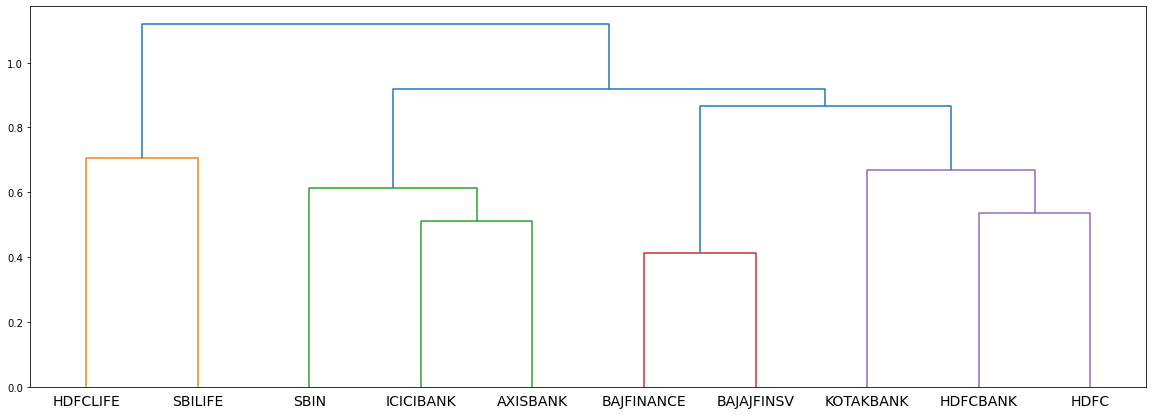

In [23]:
#Plot Dendogram
plt.figure(figsize=(20, 7))
#plt.title("Dendrograms")
dendrogram(link,labels = X.columns, leaf_font_size=14)
plt.show()

### 4.2 Steps involved in the HRP Model Design 

#### Quasi-Diagonalization and Weights Computation for HRP

Quasi-diagonalization is a matrix seriation process used in hierarchical clustering. The process involves reorganizing the covariance matrix of returns in such a way that stocks with similar returns are placed together. This matrix diagonalization allows us to distribute weights optimally following an inverse-variance allocation. For more details refer to Chapter 4 of the book.

In [24]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

#### Recursive Bisection

This step distributes the weights through recursive bisection based on the cluster covariance.

In [25]:
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar



def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

#### Comparison of HRP with MVP

So, in this step, python functions are defined for comparing the following two portfolio design approaches.

    1. MVP - Markowitz’s Minimum-Variance Portfolio
    2. HRP - Hierarchial Risk Parity

In [26]:
def getMVP(cov):

    cov = cov.T.values
    n = len(cov)
    N = 100
    mus = [10 ** (5.0 * t / N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(cov)
    #pbar = opt.matrix(np.mean(returns, axis=1))
    pbar = opt.matrix(np.ones(cov.shape[0]))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    
    # Calculate efficient frontier weights using quadratic programming
    solvers.options['show_progress'] = False
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER    
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO    
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']

    return list(wt)

def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    #plt.figure(figsize=(20, 10))
    #dn = sch.dendrogram(link, labels=cov.index.values)
    #plt.show()
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

#### Computation of the Weight Allocation for the Portfolios

In [27]:
def get_all_portfolios(returns):
    
    cov, corr = returns.cov(), returns.corr()
    hrp = getHRP(cov, corr)
    mvp = getMVP(cov)
    mvp = pd.Series(mvp, index=cov.index)
    portfolios = pd.DataFrame([mvp, hrp], index=['MVP', 'HRP']).T
    #portfolios = pd.DataFrame([ivp, hrp], index=['IVP', 'HRP']).T
    return portfolios

In [28]:
portfolios = get_all_portfolios(returns)
print(portfolios)

                 MVP       HRP
HDFCBANK    0.379984  0.187398
HDFC        0.008654  0.144215
ICICIBANK   0.000250  0.053035
KOTAKBANK   0.146117  0.136309
AXISBANK    0.000316  0.043981
SBIN        0.084268  0.094453
BAJFINANCE  0.000114  0.065628
BAJAJFINSV  0.000994  0.083711
HDFCLIFE    0.092755  0.085961
SBILIFE     0.286548  0.105309


Text(0.5, 1.0, 'HRP')

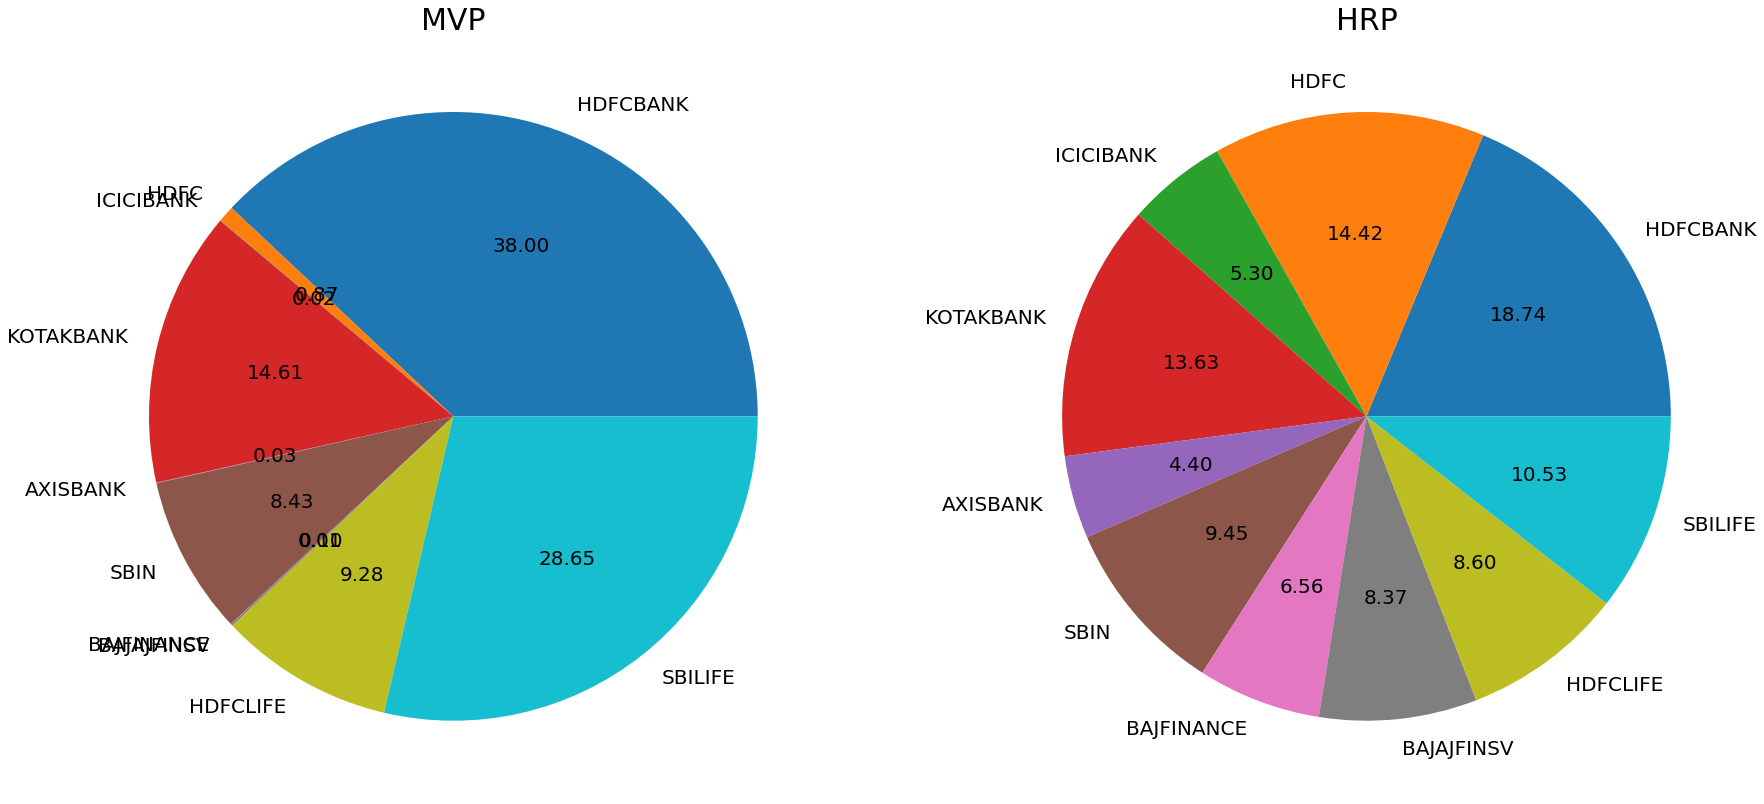

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,20))
ax1.pie(portfolios.iloc[:,0], labels= portfolios.index, autopct='%.2f', textprops={'fontsize': 20});
ax1.set_title('MVP',fontsize = 30)
ax2.pie(portfolios.iloc[:,1], labels=portfolios.index, autopct='%.2f', textprops={'fontsize': 20});
ax2.set_title('HRP',fontsize = 30)
#portfolios.plot.pie(subplots=True, figsize=(20, 10),legend = False);

In [30]:
# MVP - Markowitz’s Minimum-Variance Portfolio Weights
portfolios.iloc[:,0]

HDFCBANK      0.379984
HDFC          0.008654
ICICIBANK     0.000250
KOTAKBANK     0.146117
AXISBANK      0.000316
SBIN          0.084268
BAJFINANCE    0.000114
BAJAJFINSV    0.000994
HDFCLIFE      0.092755
SBILIFE       0.286548
Name: MVP, dtype: float64

In [31]:
# HRP - Hierarchial Risk Parity Portfolio Weights
portfolios.iloc[:,1]

HDFCBANK      0.187398
HDFC          0.144215
ICICIBANK     0.053035
KOTAKBANK     0.136309
AXISBANK      0.043981
SBIN          0.094453
BAJFINANCE    0.065628
BAJAJFINSV    0.083711
HDFCLIFE      0.085961
SBILIFE       0.105309
Name: HRP, dtype: float64

## 5. Performance Evaluation of the Portfolios 


### 5.1 Cumulative Returns - Training and Test Data 

In [32]:
Insample_Result=pd.DataFrame(np.dot(returns,np.array(portfolios)), \
                             columns=['MVP', 'HRP'], index = returns.index)
OutOfSample_Result=pd.DataFrame(np.dot(returns_test,np.array(portfolios)), \
                                columns=['MVP', 'HRP'], index = returns_test.index)

<AxesSubplot:xlabel='date', ylabel='Return'>

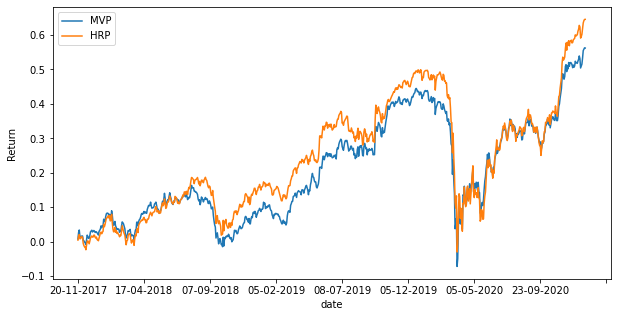

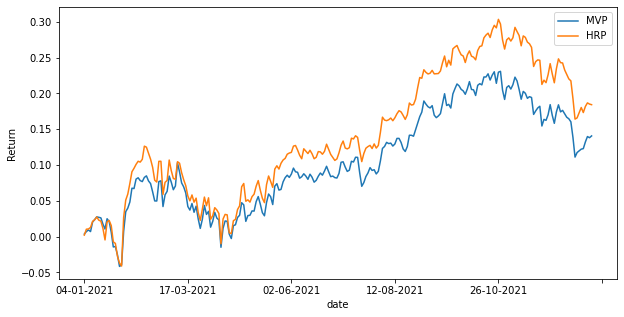

In [33]:
Insample_Result.cumsum().plot(figsize=(10, 5), ylabel = "Return")
OutOfSample_Result.cumsum().plot(figsize=(10, 5), ylabel = "Return")

In [34]:
ret_insample=Insample_Result.mean() * 252
ret_insample

MVP    0.184225
HRP    0.211509
dtype: float64

In [35]:
ret_out_of_sample = OutOfSample_Result.mean() * 252
ret_out_of_sample

MVP    0.144117
HRP    0.188835
dtype: float64

###  5.2 Sharpe Ratio and Annual Volatility - Training and Test Data

In [36]:
#In_sample Results
stddev = Insample_Result.std() * np.sqrt(252)
sharp_ratio = (Insample_Result.mean()*np.sqrt(252))/(Insample_Result).std()
Results = pd.DataFrame(dict(stdev=stddev, sharp_ratio = sharp_ratio))
Results

stdev  sharp_ratio
MVP  0.238464     0.772549
HRP  0.261012     0.810343

In [37]:
#Outof_sample Results
stddev_oos = OutOfSample_Result.std() * np.sqrt(252)
sharp_ratio_oos = (OutOfSample_Result.mean()*np.sqrt(252))/(OutOfSample_Result).std()
Results_oos = pd.DataFrame(dict(stdev_oos=stddev_oos, sharp_ratio_oos = sharp_ratio_oos))
Results_oos

stdev_oos  sharp_ratio_oos
MVP   0.179692         0.802021
HRP   0.198297         0.952284